 I have Used this dataset from kaggle https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

In [79]:
import numpy as np 
import pandas as pd 

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio 

from tensorflow.keras.layers import Dense , Input ,Flatten , Conv1D , Dropout
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling1D
from tensorflow.keras.models import Model , Sequential 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau 
from tensorflow.keras.utils import to_categorical
    
import tensorflow as tf  

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [72]:
ravdess="/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
ravdess_directory_list = os.listdir(ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1) 

ravdess_df.replace({'Emotions': {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}}, inplace=True)
ravdess_df.head()


,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


**Visualisation**

In [4]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

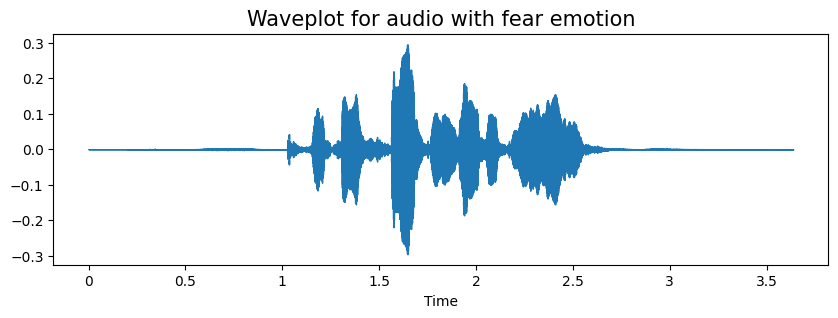

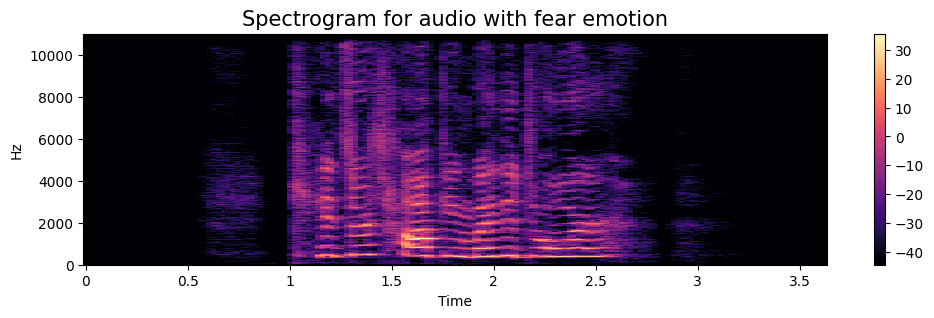

In [5]:
emotion='fear'
path = np.array(ravdess_df.Path[ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

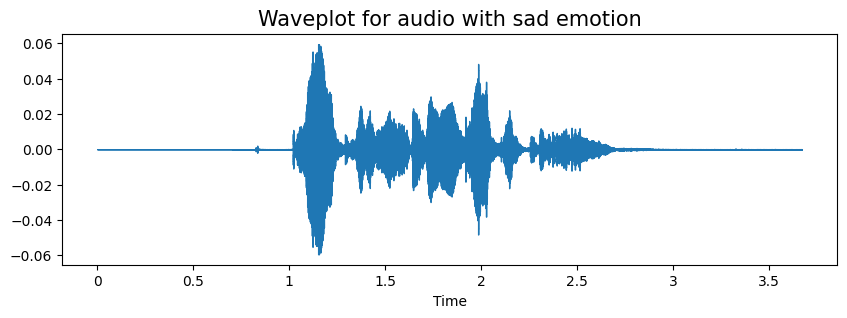

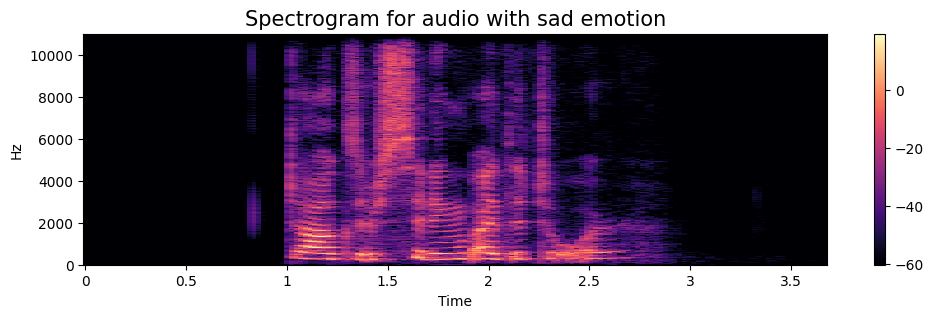

In [6]:
emotion='sad'
path = np.array(ravdess_df.Path[ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

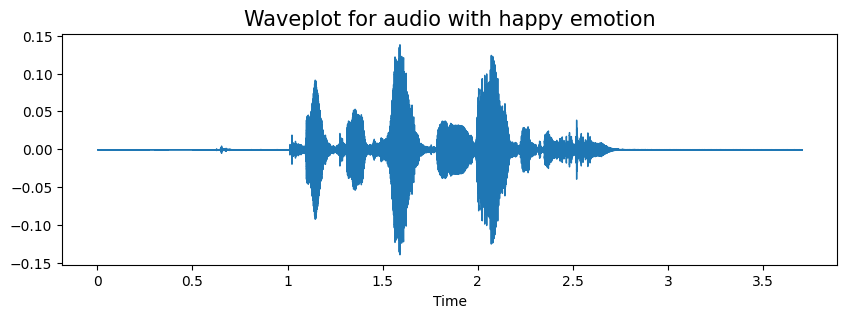

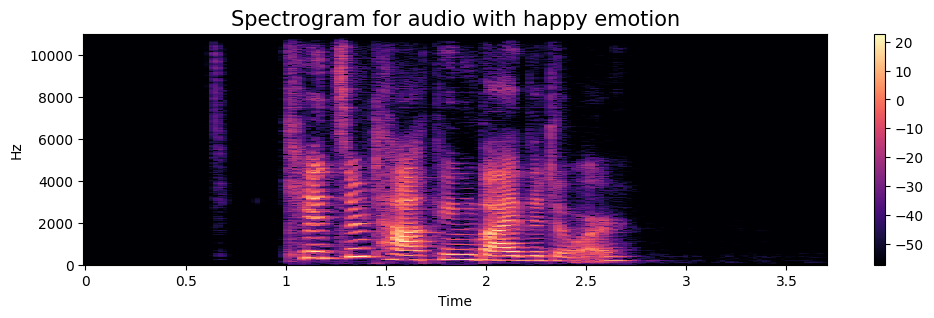

In [7]:
emotion='happy'
path = np.array(ravdess_df.Path[ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

**Data Augmentation**

 Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

In [29]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# taking any example and checking for techniques.
path = np.array(ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

**Simple Audio**

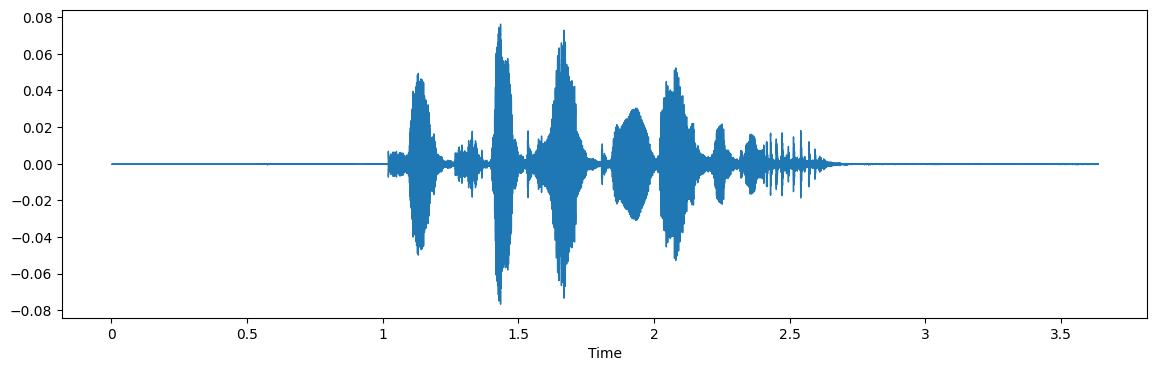

In [35]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

**Noise Injection**

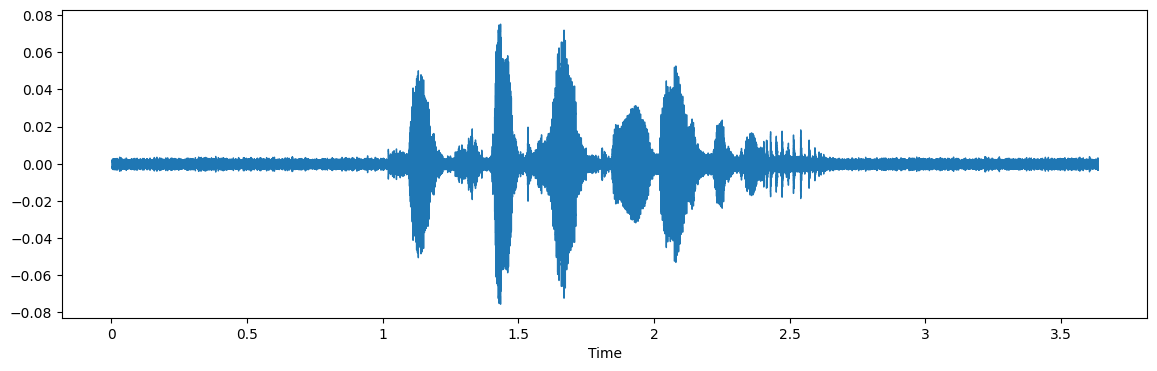

In [30]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**Shifting**

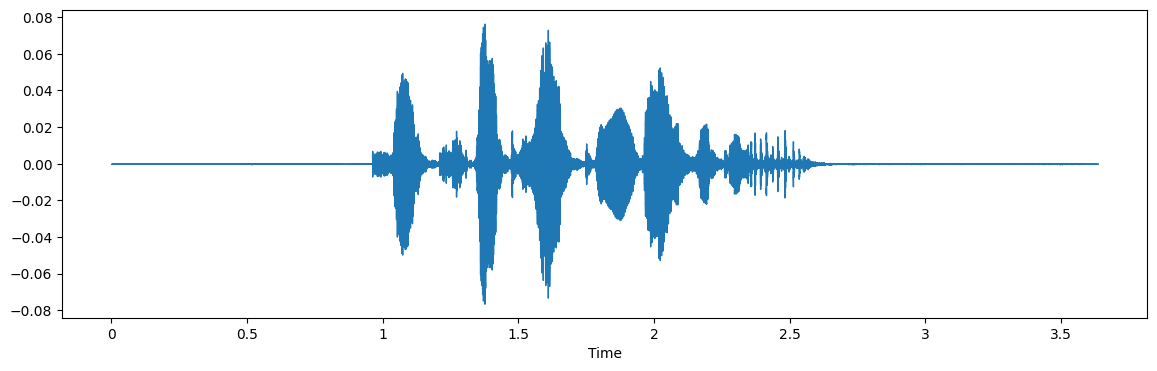

In [36]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**Feature Extraction**

In [50]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result 


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    return result

In [57]:
X, Y = [], []
for path, emotion in zip(ravdess_df.Path, ravdess_df.Emotions):
    feature = get_features(path)
    if feature is not None:
        for ele in feature:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)

In [59]:
len(X), len(Y), ravdess_df.Path.shape

(2880, 2880, (1440,))

In [60]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.306989,0.699290,0.728030,0.700715,0.680606,0.692303,0.707830,0.694811,0.674347,0.672466,...,0.000534,0.000513,0.000405,0.000413,0.000560,0.000657,0.000584,0.000454,3.181547e-04,surprise
2,0.256113,0.621621,0.580278,0.598515,0.628296,0.598015,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802853e-07,neutral
3,0.277488,0.653637,0.647157,0.698305,0.723319,0.688739,0.638588,0.679544,0.716409,0.702652,...,0.000052,0.000050,0.000047,0.000046,0.000042,0.000041,0.000043,0.000039,3.457879e-05,neutral
4,0.180632,0.621834,0.632666,0.567364,0.558964,0.592169,0.638070,0.635625,0.634870,0.589902,...,0.000083,0.000103,0.000160,0.000099,0.000060,0.000060,0.000056,0.000033,3.975709e-06,disgust


**Data Preparation**

In [61]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [62]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [63]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162), (2160, 8), (720, 162), (720, 8))

In [64]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162), (2160, 8), (720, 162), (720, 8))

In [65]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2160, 162, 1), (2160, 8), (720, 162, 1), (720, 8))

**Modelling**

In [73]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])



In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)          

In [75]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
34/34 [==============================] - 9s 211ms/step - loss: 1.9883 - accuracy: 0.1912 - val_loss: 1.9361 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 7s 201ms/step - loss: 1.9261 - accuracy: 0.2222 - val_loss: 1.8861 - val_accuracy: 0.2681 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 7s 215ms/step - loss: 1.8748 - accuracy: 0.2769 - val_loss: 1.8177 - val_accuracy: 0.2986 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 7s 202ms/step - loss: 1.8401 - accuracy: 0.2745 - val_loss: 1.7590 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 7s 202ms/step - loss: 1.7870 - accuracy: 0.2926 - val_loss: 1.6936 - val_accuracy: 0.3528 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 7s 212ms/step - loss: 1.7331 - accuracy: 0.3065 - val_loss: 1.6677 - val_accuracy: 0.3736 - lr: 0.0010
Epoch 7/50
34/34 [==============================] - 7s 200ms/step - lo

23/23 [==============================] - 1s 25ms/step - loss: 1.6352 - accuracy: 0.6389
Accuracy of our model on test data :  63.88888955116272 %


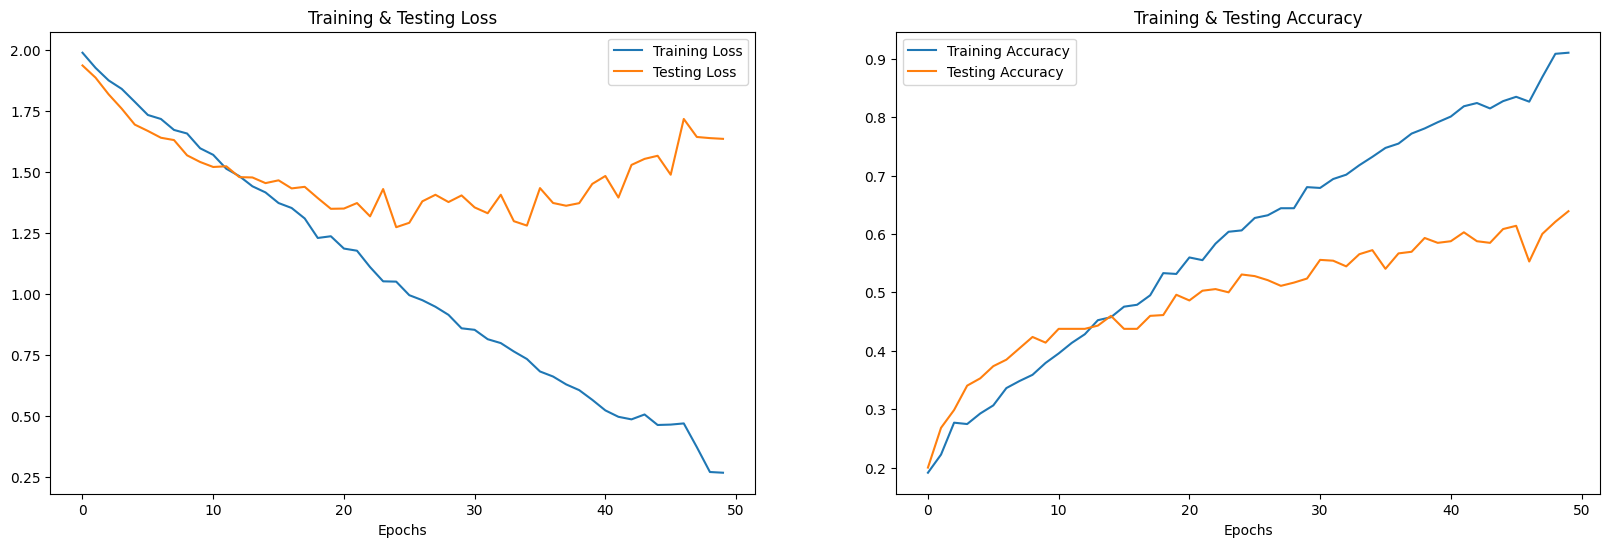

In [76]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [77]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

23/23 [==============================] - 1s 24ms/step


In [78]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,sad,sad
2,calm,calm
3,disgust,fear
4,calm,calm
5,happy,disgust
6,disgust,disgust
7,surprise,angry
8,sad,neutral
9,surprise,sad


**We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..**


**We overall achieved 64% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.**